In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [4]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#FoodFeedOtherAcross>2. Across Farm Sizes</a><br>
    <a href=#FoodFeedOtherWithin>3. Within Farm Sizes</a><br>
    <a href=#GlobalEstimates>3. Global Estimates</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>

    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Project_Overview'>Project Overview</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage'>Data Coverage</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/General_Results'>General Results</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate'>Global Estimates</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>Global Estimate</h1></center><br><br><br>

In [843]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
# from __future__ import print_function
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [4]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

In [186]:
PATH_our_data = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
PATH_lowder = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/External_Datasets/Lowder_Supp_cleaned.csv'
data_orig = read_data_init(PATH_our_data)
lowder = pd.read_csv(PATH_lowder)
lowder = lowder.loc[lowder['Holdings/ agricultural area'] == 'Holdings']
lowder = lowder.drop(lowder[[u'year', u'Region', u'Holdings/ agricultural area']], axis=1)

In [187]:
b = [0.5, 1.5, 3.5, 7.5, 15., 75., 150., 350., 750., 1500.]
c = dict(zip(lowder.columns[2:], b))

for key, value in c.iteritems():
    lowder[key] = value * lowder[key]

In [8]:
has = pd.DataFrame(lowder.NAME_0.unique(), columns=['NAME_0'])
ours = pd.DataFrame(data_orig.query("production_Food_kcal == production_Food_kcal").NAME_0.unique(), 
                    columns=['NAME_0'])
together = pd.merge(has, ours, how='outer', on='NAME_0')
num_tog = len(together.NAME_0.unique())
num_subnational = len(data_orig.query("production_Food_kcal == production_Food_kcal & NAME_1 != '1'").NAME_0.unique())

**Goal:**<br><br>
Can we make a simple model, at the country level, to estimate production of food by farm size, such as?<br><br>

$$Food \ produced \ our \ data_{ic} = Food \ produced \ FAO \ data_{c} + \% \ operational \ holdings_{ic}, \quad Where, \ i = farm \ size \ and \ c = country$$

<br>
Other independent variables, may include:
- GDP (gross and PPP)
- Total agricultural area
- Total number of farms
- Percent GDP from agriculutre

<br>
Note: the FAO data does not have production by farm size, but Lowder et al. 2014 has the distributions of farm operations for 111 countries. Combined with our dataset we would have {{num_tog}} country level estimates for the amount of food produced by each farm size, and {{num_subnational}} countries with subnational resolution. 
- How much of the global area would this cover?
Note: percent area would be better, but China and other large countries do not have info available.<br><br>

For the countries not in our dataset we won't have the amount of food produced per farm size. We will need to estimate this based on the FAO data. First, we will measure the relationship between the FAO data and our data - comparing amount of food produced per country without grouping farm sizes. Then we will compare the relationship between the FAO data and our data when we group by farm sizes. The assumption will be that there will be less of a relationship after we group by farm sizes since the FAO production cannot be evenly allocated to each farm size class. To remedy this error, and estimate a better relationship between the FAO data and each of the farm size classes' food production in our data, we will use Lowder et al.'s distribution of farm operations per country. Hopefully, the amount of food produced per farm size will be a function of the FAO food production data and Lowder et. al's farm size distributions.

Below I take the amount food produced as in our dataset and compare to the amount food produced as in the FAO data.

Then, I plot the relationship per farm size class. The linear coefficient and the RANSAC (RANdom SAmple Consensus) coefficient are provided in the axes titles. RANSAC is a method by which outliers can be accounted for, essentially, it is an algorithm that randomly excludes subsets of the dataset, fits a model to the subset, repeats n-number of times, and determines outliers.

In [438]:
tmp = data_orig.copy()
tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal']

tmp['Prod_FAO'] = tmp['Area_FAO'] * tmp['Yield_FAO']
tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal']

pivot = pd.pivot_table(tmp, 
                       index=['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'year'],
                       values=['Prod_FAO_kcal', 'production_kcal'],
                       aggfunc=np.nansum)

pivot1 = pivot.reset_index()

In [471]:
def plot_all_fao_v_ours(data, ax=None):

    tmp = data.copy()
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

#     fig = plt.figure(figsize=[5,5])
#     ax = fig.add_subplot(111)

    x = tmp['log_Prod_FAO_kcal']
    y = tmp['log_production_kcal']

    X = x.as_matrix()
    y = y.as_matrix()
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit line using all data
    lr = linear_model.LinearRegression(normalize=True)
    lr.fit(X, y)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y = lr.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    lw = 2
    ax.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='o',
                label='Inliers')
    ax.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='o',
                label='Potential Outliers')
    ax.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
    ax.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
             label='RANSAC regressor')
    ax.legend(loc='lower right')
    ax.set_xlabel("FAO data produced \n(log kcal)")
    ax.set_ylabel("Our data food produced \n(log kcal)")

    ax.set_title('\n{} \n'
                 'OLS R^2: {} \n'
                 'RANSAC coeff: {} \n '.format('All farms',
                                               round(lr.score(X, y), 2), 
                                               round(ransac.estimator_.coef_, 2)),
                fontsize=14)

#     fig.tight_layout()
#     plt.show()
    
    ceff_ln = round(lr.coef_, 2)
    coeff_rn = round(ransac.estimator_.coef_, 2)
    
    return ax

In [472]:
# tmp['production_fix_kcal'].corr(tmp['Prod_FAO_kcal'], method='spearman')

In [473]:
def plot_fao_ours_fs(data, 
                     x_var='log_Prod_FAO_kcal', 
                     y_var='log_production_kcal',
                     x_lab='FAO data food produced \n(log kcal)',
                     y_lab='Our data food produced \n(log kcal)'):
    
    fig = plt.figure(figsize=[20,20])
    fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
          '(500, 1000]', '(1000, 100000]']
    
    ax1 = fig.add_subplot(3,4,1)
    plot_all_fao_v_ours(pivot1, ax=ax1)
    

    for i in xrange(1, len(fs)+1):

        try:
            tmp2 = data.loc[data['Farm_Sizes'] == fs[i]]
            x = tmp2[x_var]
            y = tmp2[y_var]
            l = linregress(x,y)

            ax = fig.add_subplot(3,4,i+1)

            X = x.as_matrix()
            y = y.as_matrix()
            X = X.reshape(-1, 1)
            y = y.reshape(-1, 1)

            # Fit line using all data
            lr = linear_model.LinearRegression()
            lr.fit(X, y)

            # Robustly fit linear model with RANSAC algorithm
            ransac = linear_model.RANSACRegressor()
            ransac.fit(X, y)
            inlier_mask = ransac.inlier_mask_
            outlier_mask = np.logical_not(inlier_mask)

            # Predict data of estimated models
            line_X = np.arange(X.min(), X.max())[:, np.newaxis]
            line_y = lr.predict(line_X)
            line_y_ransac = ransac.predict(line_X)

            # # Compare estimated coefficients
        #     print("Estimated coefficients (true, linear regression, RANSAC):")
        #     print(lr.coef_, ransac.estimator_.coef_)

            lw = 2
            ax.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='o',
                        label='Inliers')
            ax.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='o',
                        label='Outliers')
            ax.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
            ax.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
                     label='RANSAC regressor')
            ax.legend(loc='lower right')
            ax.set_xlabel(x_lab)
            ax.set_ylabel(y_lab)

            ax.set_title('\n{} ha\n'
                         'Linear coeff: {} \n'
                         'RANSAC coeff: {} \n '.format(fs[i][1:-1],
                                                       round(lr.coef_, 2), 
                                                       round(ransac.estimator_.coef_, 2)),
                        fontsize=14)
        except:
            pass
    
    fig.tight_layout()
    
    return plt.show()

def prep_plot():
    
    tmp = data_orig.copy()
    tmp['Prod_FAO'] = tmp['Area_FAO'] * tmp['Yield_FAO']
    tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal']
    tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal']

    tmp = tmp.loc[:, ['NAME_0',
                      'Farm_Sizes', 'year', 'production_kcal', 
                      'Prod_FAO_kcal']]
    pivot1 = pd.pivot_table(tmp, 
                           index=['NAME_0', 'Farm_Sizes', 'year'],
                           values=['production_kcal'],
                           aggfunc=np.nansum)
    pivot1 = pivot1.reset_index()

    pivot2 = pd.pivot_table(tmp, 
                           index=['NAME_0', 'Farm_Sizes', 'year'],
                           values=['Prod_FAO_kcal'],
                           aggfunc=np.nansum)
    pivot2 = pivot2.reset_index()

    pivot = pd.merge(pivot1, pivot2, on=['NAME_0', 'year', 'Farm_Sizes'], how='outer')
    pivot = pivot.dropna()

    tmp = pivot.copy()
    tmp['production_kcal'] = np.where(tmp['production_kcal'] == 0.0, np.nan, tmp['production_kcal'])
    tmp['Prod_FAO_kcal'] = np.where(tmp['Prod_FAO_kcal'] == 0.0, np.nan, tmp['Prod_FAO_kcal'])
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

    return tmp, pivot

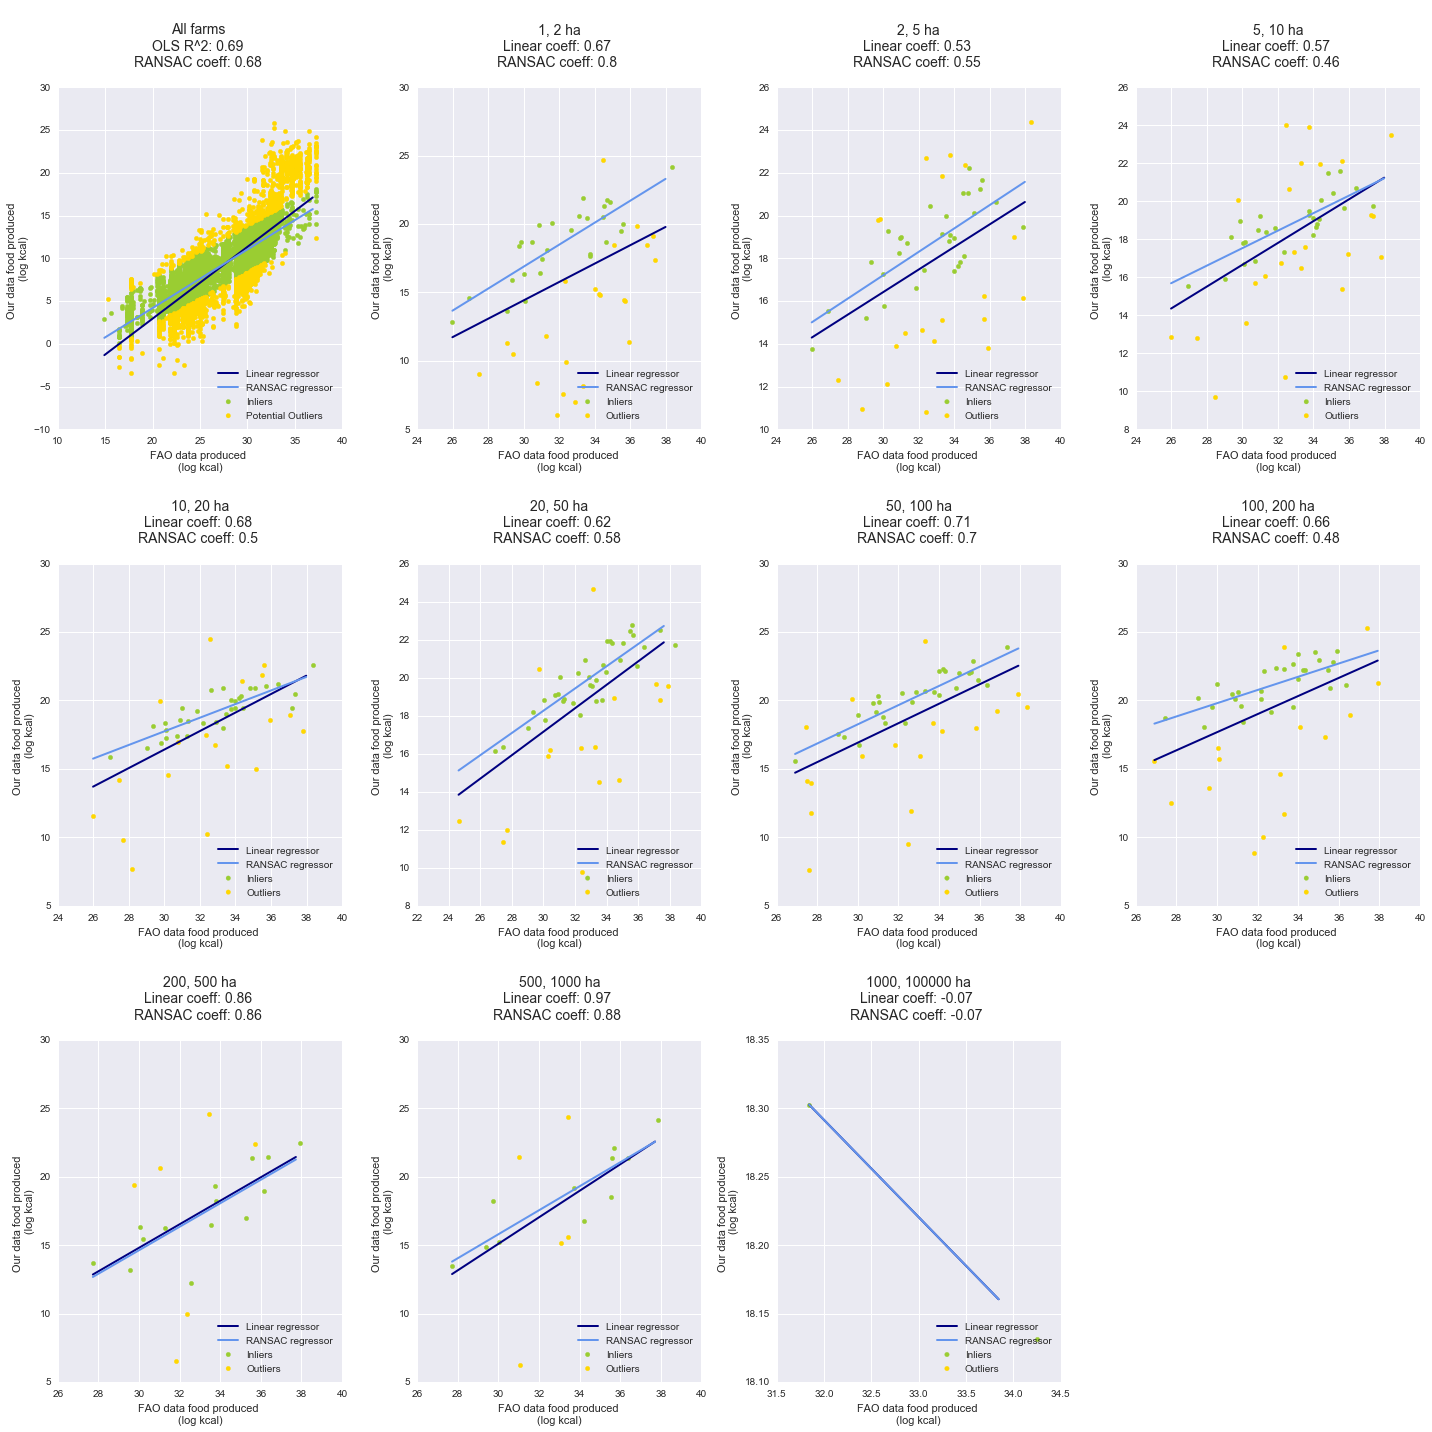

In [474]:
tmp, pivot = prep_plot()
plot_fao_ours_fs(tmp, x_var='log_Prod_FAO_kcal', y_var='log_production_kcal')

First, I plot all the farm size classes together. We can see that there are is a lot of variance. After accounting for the outliers via the RANSAC method, the coefficient is {{coeff_rn}} (compared to the linear coefficient {{ceff_ln}}). Note, this is a log-log plot as there is heavy skew.

Then, I compare the cofficients when we seperate them out by farm size group. As expected, the coefficients decrease in absolute value since the FAO data cannot simply be divided equally and allocated to each far size class. Again, these are a log-log plots as there is heavy skew.

We can see strong relationships between the FAO data and ours with the exception of the largest farm size class. We will drop this class for the remainder of the analysis, then revist.

Next, we use Lowder et al. 2014 dataset, we can use the number of farm operations per farm size class. Note, the Lowder et al. data also has area under each farm size class, but only for a select number of countries, which excludes large producers not in our dataset, such as, China).

So here we grab the Lowder et al. data and construct percentages of farm operations per farm size class. Then we will test the relationships between the percentage of food produced by a given farm size class and percent of operations by farm size class for each country in our dataset. If there is a strong relationship we can test the error, then predict to countries we do not have in our dataset.

Note: Lowder et al.'s data relies on census data ranging from 1987 to 2005, with a median year of 2000. We assume the same distrubutions in our dataset for the given year we collected data.

In [484]:
tmp = tmp.loc[tmp['Farm_Sizes'] != '(1000, 100000]']
pivot = tmp.copy()
lowder2 = lowder.copy()

for c in lowder.columns[2:]:
    lowder2[c] = lowder[c] / lowder['Total']

lowder2 = lowder2.drop(['Total'], axis=1)
lowder2 = pd.melt(lowder2, id_vars='NAME_0', var_name='Farm_Sizes', value_name='Perc_Farms')
pivot['Farm_Sizes'] = pivot['Farm_Sizes'].astype(str)
pivot = pd.merge(pivot, lowder2, how='left', on=['Farm_Sizes', 'NAME_0'])
pivot['Proxy_fs'] = pivot['Prod_FAO_kcal'] * pivot['Perc_Farms']
pivot['log_Proxy_fs'] = np.log(pivot['Proxy_fs'])

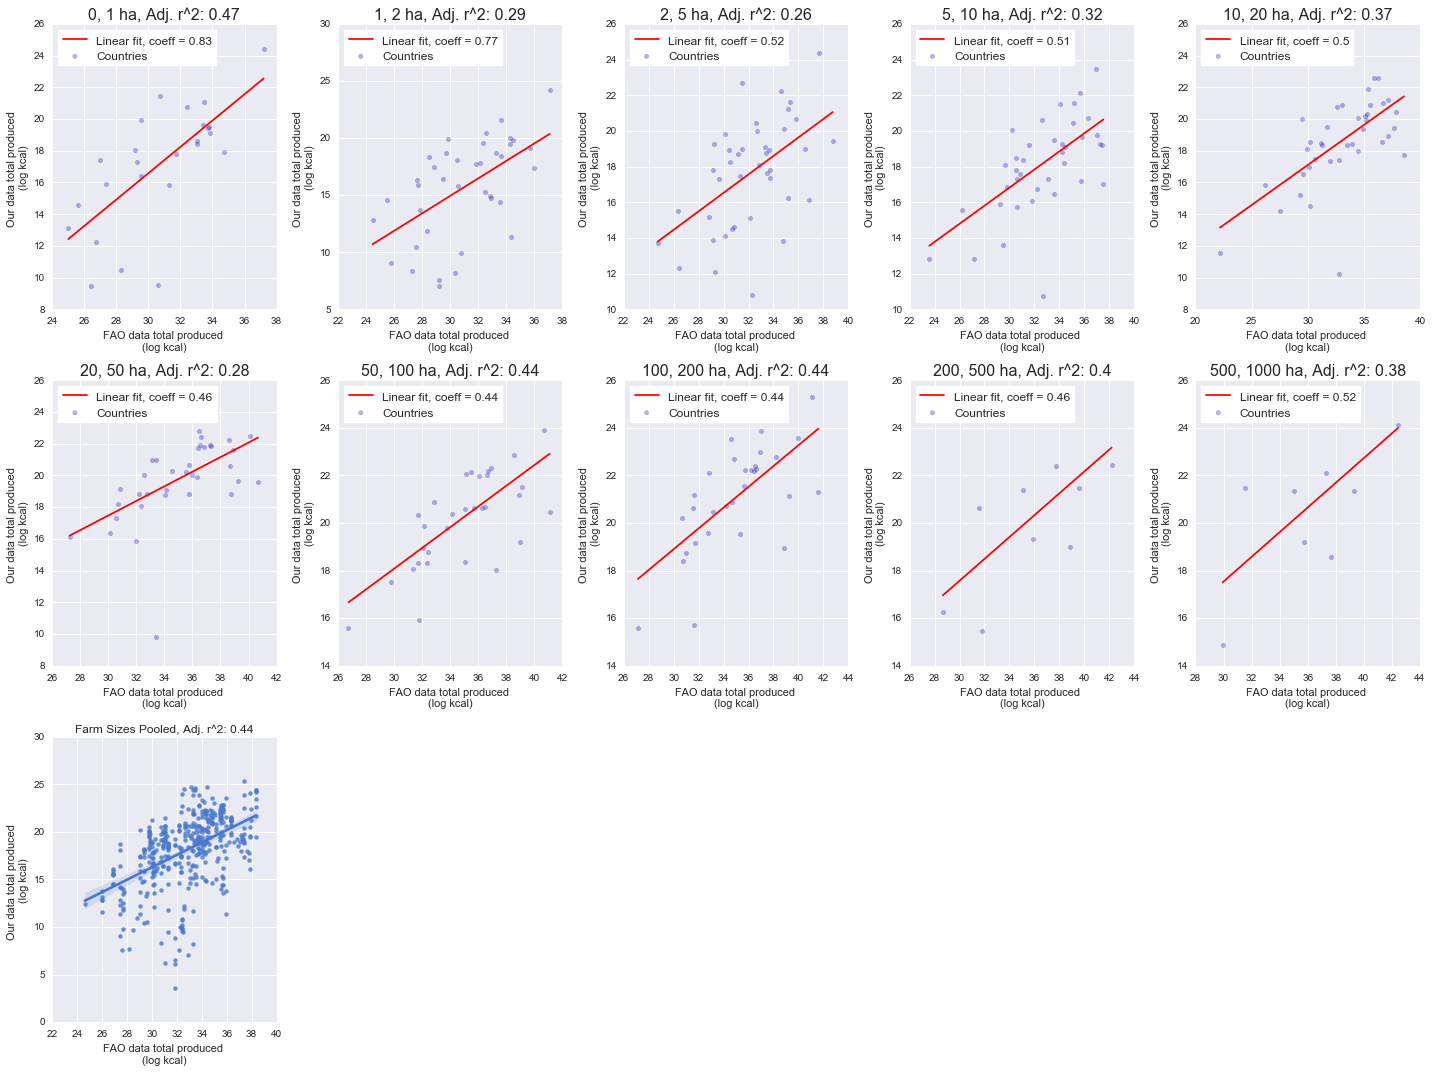

In [485]:
tmp = pivot.copy()

fs = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
          '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
          '(500, 1000]']

f = []
r = []

fig = plt.figure(figsize=[20,15])

for i in xrange(len(fs[:])):

    tmp2 = tmp.loc[tmp['Farm_Sizes'] == fs[i]]
    est = smf.ols(formula="log_production_kcal ~ log_Proxy_fs", 
                  data=tmp2).fit()
#     est = est.get_robustcov_results()
    f.append(fs[i])
    r.append(round(est.rsquared_adj, 2))
    
    ax = fig.add_subplot(3,5,i+1)
    dv_plotagainst = tmp2['log_production_kcal']
    iv_plotagainst = tmp2['log_Proxy_fs']
    var_linspace = np.linspace(iv_plotagainst.min(), iv_plotagainst.max(), 100)[:, np.newaxis]
    ax.scatter(iv_plotagainst, dv_plotagainst, alpha=0.3, label='Countries')
    ax.set_xlabel('FAO data total produced \n(log kcal)')
    ax.set_ylabel('Our data total produced \n(log kcal)')
    # est.params[0] is intercept
    # est.params[1] is coefficeint 1.. and so on
    ax.plot(var_linspace, est.params[0] + est.params[1] * var_linspace + est.params[1] * 0, 'r', 
            label='Linear fit, coeff = {}'.format(round(est.params[1], 2)))  
    ax.set_title('{} ha, Adj. r^2: {}'.format(fs[i][1:-1], round(est.rsquared_adj, 2)), fontsize=16)
    legend = ax.legend(loc='upper left', 
                       fontsize=12, 
                       frameon=1)
    frame = legend.get_frame()
    frame.set_color('white')

ax = fig.add_subplot(3,5,len(fs[:][-1]))
est = smf.ols(formula="log_production_kcal ~ log_Proxy_fs", 
                  data=tmp).fit()
sns.regplot(x='log_Prod_FAO_kcal', y='log_production_kcal', 
           data=tmp,
           truncate=True,
           ax=ax);
ax.set_xlabel('FAO data total produced \n(log kcal)')
ax.set_ylabel('Our data total produced \n(log kcal)')

ax.set_title('Farm Sizes Pooled, Adj. r^2: {}'.format(round(est.rsquared_adj, 2), fontsize=16))

fig.tight_layout()
plt.show()

In [129]:
# %load_ext rpy2.ipython
# %R require(ggplot2); require(tidyr); require(lme4); require(multcomp); require(plotrix);

In [225]:
# %%R -i tmp

# m1 <- lm(log_production_kcal ~ log_Proxy_fs, data=tmp)  # log_Prod_FAO_kcal, log_Proxy_fs
# print(summary(m1))
# plot(m1)
# hist(m1$residuals, breaks=20)

Let's grab the GDP (gross, PPP, and percentage agriculture) and see if the we can minimize error.

In [486]:
PATH_FAO_GDP = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/FaoStat/FAOSTAT/Macro-Statistics_Key_Indicators_E_All_Data_(Norm).csv'
df_gdp = pd.read_csv(PATH_FAO_GDP)

In [487]:
tmp_gdp = df_gdp.copy()
tmp_gdp = tmp_gdp.loc[(tmp_gdp['Element'] == 'Value US$, 2005 prices') & 
                      (tmp_gdp['Item'] != 'Gross Fixed Capital Formation'), 
                     ['Country', 'Year', 'Item', 'Value']]

tmp_gdp = pd.pivot_table(tmp_gdp, index=['Country', 'Year'], columns=['Item'], values='Value').reset_index()
tmp_gdp = tmp_gdp.sort_values(['Country', 'Year'])

multi_index = pd.MultiIndex.from_product([tmp_gdp['Country'].unique(),
                                          tmp_gdp['Year'].unique()],
                                         names=['Country', 'Year'])

tmp_gdp = tmp_gdp.set_index(['Country', 'Year']).reindex(multi_index).reset_index()

tmp_gdp = tmp_gdp.set_index(['Country', 'Year'])
tmp_gdp = tmp_gdp.interpolate(method='linear',
                              axis=0,
                              limit_direction='both')
tmp_gdp = tmp_gdp.reset_index()

tmp2 = pivot.copy()

tmp2 = pd.merge(tmp2, tmp_gdp, 
                left_on=['NAME_0', 'year'], 
                right_on=['Country', 'Year'],
                how='left')
tmp2.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
tmp2.rename(columns=lambda x: x.replace(',', ''), inplace=True)

In [489]:
def std_column(data, column):
    
    x = data[column]
    xbar = data[column].mean()
    std_ = data[column].std()
    data[column + '_std'] = (x - xbar) / std_
    
    return data

vars_to_std = ['production_kcal', 
               'Prod_FAO_kcal', 
               'Proxy_fs',
               'Gross_Domestic_Product', 
               'Gross_Domestic_Product_per_capita', 
               'Value_Added_Agriculture_Forestry_and_Fishing']

for v in vars_to_std:
    tmp2 = std_column(tmp2, v)
    tmp2['log_' + v] = np.log(tmp2[v])

In [655]:
def plot_regression_pandas(data, model, dv='log_production_kcal', iv='log_Proxy_fs', est_parm=-4):

    fig = plt.figure(figsize=[15, 10])
    ax = fig.add_subplot(221)
    
    dv_plotagainst = data[dv]
    iv_plotagainst = data[iv]
    
    var_linspace = np.linspace(iv_plotagainst.min(), iv_plotagainst.max(), 100)[:, np.newaxis]
    ax.scatter(iv_plotagainst, dv_plotagainst, alpha=0.3, label='Countries')
    ax.plot(var_linspace, model.params[0] + model.params[est_parm] * var_linspace + model.params[est_parm] * 0, 'r', 
            label='Linear fit, coeff = {}'.format(round(model.params[est_parm], 2)))  
    
        
    ax.set_xlabel('FAO data food produced \n(log kcal)')
    ax.set_ylabel('Our data food produced \n(log kcal)')
    ax.set_title('All farms with farm sizes as dummies\nAdj. r^2: {}'.format(round(model.rsquared_adj, 2)), 
                 fontsize=14)
    legend = ax.legend(loc='upper left', 
                       fontsize=12, 
                       frameon=1)
    frame = legend.get_frame()
    frame.set_color('white')

    ax2 = fig.add_subplot(222)
    sns.kdeplot(model.resid, ax=ax2);
    ax2.set_title('Density Plot')

    ax3 = fig.add_subplot(223)
    sns.regplot(model.resid, model.fittedvalues, ax=ax3)
    ax3.set_xlabel('Fitted')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Fitted vs. Residuals')

    ax4 = fig.add_subplot(224)
    stats.probplot(model.resid, dist="norm", plot=ax4);
    ax4.get_lines()[0].set_marker('.')
    ax4.get_lines()[0].set_color('k')
    ax4.set_title('Q-Q Plot')
    fig.tight_layout()
    
    return plt.show()


def check_nonconstant_variance(model):
    
    est_df = pd.concat([pd.DataFrame(model.resid, columns=['resid']), 
                        pd.DataFrame(model.fittedvalues, columns=['fitted'])],
                      axis=1)
    est_check1 = smf.ols(formula="""resid ~ fitted""", data=est_df).fit()
    
    print(est_check1.summary())

In [546]:
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111)
# sns.corrplot(tmp2.loc[:, ['log_production_kcal',
#                           'log_Prod_FAO_kcal',
#                           'Perc_Farms',
#                           'Proxy_fs', 
#                           'Gross_Domestic_Product_per_capita_std',
#                           'Gross_Domestic_Product_std', 
#                           'Value_Added_Agriculture_Forestry_and_Fishing_std']],
#             diag_names=False, ax=ax);

In [581]:
tmp4 = tmp2.copy()

est = smf.ols(formula="""log_production_kcal ~ 
                         log_Prod_FAO_kcal + 
                         Perc_Farms +
                         np.log(Prod_FAO_kcal * Perc_Farms) +
                         Gross_Domestic_Product_std +
                         Gross_Domestic_Product_per_capita_std +
                         Value_Added_Agriculture_Forestry_and_Fishing_std""", 
              data=tmp4).fit()
est = est.get_robustcov_results()
print est.summary()
# tmp4.dropna()['log_Value_Added_Agriculture_Forestry_and_Fishing'].corr(est.resid)  # check each IV against resid
# plot_regression_pandas(tmp4, est, dv='log_production_kcal', iv='log_Prod_FAO_kcal', est_parm=-1)
# Note: high Jarque_Bera, low p = results non-normal
# Note: Durbin-Watson close to zero means positive autocorrelation, close to 4 is negative autocorrelation. 
#       2 is non-correlated. (calculated by: value of the error minus the previous error are calculated and squared)
# check_nonconstant_variance(est)  # A basic test for heteroskedasticity (null hypothesis = no relationship)

                             OLS Regression Results                            
Dep. Variable:     log_production_kcal   R-squared:                       0.550
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     99.81
Date:                 Mon, 28 Aug 2017   Prob (F-statistic):           9.25e-68
Time:                         15:36:44   Log-Likelihood:                -671.98
No. Observations:                  299   AIC:                             1358.
Df Residuals:                      292   BIC:                             1384.
Df Model:                            6                                         
Covariance Type:                   HC1                                         
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------

Adding a few economic variables increased the adjusted r^2 to {{round(est.rsquared_adj, 2)}}, but there is some mulicollinearity (Durbin-Watson = 0.64) and heteroskedasticity (prob(JB) is highly significant); these statistics were corroborated visually, even with a robust covariance matrix (HC1). A next step is to run a Generalized Linear model (GLM) that can handle these issues.

# <a name="LeftOff"></a>
# <h3>Left Off</h3><br><br>

To do:
- Make sure y is in fact log-normal
- Forcing the covariance matrix in a GLS model to mimic a nearest neighbor matrix corrected the multicollinearity
- Trying to correct for heteroskedasticity issues. Tried Box-c tranformation, and did not help q-q plot or Jarque-Bera test results.
- Test if adding farm size dummies helps or hinders (look into multicollinearity issue here)
- Eventually, add additional exogenous variables to increase fit

NormaltestResult(statistic=39.068417887673334, pvalue=3.2839825998363407e-09)

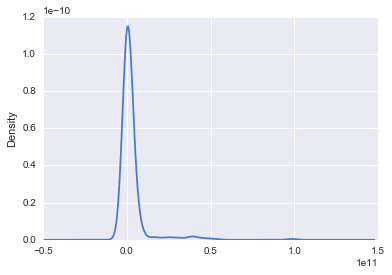

In [842]:
data['production_kcal'].plot(kind='kde')
stats.normaltest(np.log(data['production_kcal']))
# data['production_kcal'].describe()

In [816]:
data = sm.datasets.longley.load()
data = tmp2.copy()

data = data.loc[:, ['production_kcal', 'log_production_kcal', 'production_kcal_std',
                    'Proxy_fs', 'log_Proxy_fs', 'Proxy_fs_std',
                    'Prod_FAO_kcal', 'log_Prod_FAO_kcal', 'Prod_FAO_kcal_std',
                    'Gross_Domestic_Product_per_capita_std',
                    'Gross_Domestic_Product_std', 
                    'Value_Added_Agriculture_Forestry_and_Fishing_std']]

data = data.dropna()

data = data.dropna()
data_exog = data.loc[:, ['log_Prod_FAO_kcal',
                         'log_Proxy_fs', 
                         'Gross_Domestic_Product_per_capita_std',
                         'Gross_Domestic_Product_std', 
                         'Value_Added_Agriculture_Forestry_and_Fishing_std']]

data_endog = data.loc[:, ['log_production_kcal']]

    
data_exog = data_exog.as_matrix()
data_endog = data_endog.as_matrix()

data_exog = sm.add_constant(data_exog)
# data.head()

In [817]:
ols_resid = sm.OLS(data_endog, data_exog, missing=True).fit().resid
resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()

# Since this is correlated, we can adjust the covariance matrix in a GLS model
# print("t-stat: {} \np-value: {}".format(round(resid_fit.tvalues[1], 2), round(resid_fit.pvalues[1]), 2))


# Nice tutorial on GLS: http://www.statsmodels.org/dev/examples/notebooks/generated/gls.html
# A toeplitz matrix mimics nearestneighbor covaraiance (multicollinearity), 
# use with rho from our OLS model to map onto our data
from scipy.linalg import toeplitz
order = toeplitz(range(len(ols_resid)))
rho = resid_fit.params[1]
sigma = rho**order
gls_model = sm.GLS(data_endog, data_exog, sigma=sigma, missing=True)
gls_results = gls_model.fit()
# gls_results = gls_results.get_robustcov_results()
print(gls_results.summary())
print('\n\n')

# However, since the exact rho is not known, we can estimate a 'feasible gls'
# ... But it turns out using nearest neighbor covariance structure worked very well. Use above model.}
# glsar_model = sm.GLSAR(data_endog, data_exog, 1)
# glsar_results = glsar_model.iterative_fit(1)
# gls_results = gls_results.get_robustcov_results()
# print(glsar_results.summary())


                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            GLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     82.62
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           6.63e-54
Time:                        17:43:08   Log-Likelihood:                -574.46
No. Observations:                 299   AIC:                             1161.
Df Residuals:                     293   BIC:                             1183.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0324      2.384      2.530      0.0

In [836]:
# #http://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html

# from statsmodels.stats.outliers_influence import OLSInfluence
# test_class = OLSInfluence(gls_results)
# len(test_class.dfbetas[:5,:])

# np.linalg.cond(gls_results.model.exog)

# name = ['Lagrange multiplier statistic', 'p-value', 
#         'f-value', 'f p-value']
# test = sms.het_breushpagan(gls_results.resid, gls_results.model.exog)
# zip(name, test)

# name = ['F statistic', 'p-value']
# test = sms.het_goldfeldquandt(gls_results.resid, gls_results.model.exog)
# zip(name, test)

# name = ['t value', 'p value']
# test = sms.linear_harvey_collier(gls_results)
# zip(name, test)

In [818]:
# check_nonconstant_variance(glsar_results)

In [819]:
# plt.hist(gls_results.resid);

def plot_regression(data_endog, data_exog, model):

    fig = plt.figure(figsize=[15, 10])
    ax = fig.add_subplot(221)
    
    dv_plotagainst = data_endog[:, 0]
    iv_plotagainst = data_exog[:, 1]
    est_parm = 1
    
#     var_linspace = np.linspace(iv_plotagainst.min(), iv_plotagainst.max(), 100)[:, np.newaxis]
#     ax.scatter(iv_plotagainst, dv_plotagainst, alpha=0.3, label='Countries')
#     ax.plot(var_linspace, model.params[0] + model.params[est_parm] * var_linspace + model.params[est_parm] * 0, 'r', 
#             label='Linear fit, coeff = {}'.format(round(model.params[est_parm], 2)))  
    sns.regplot(iv_plotagainst, dv_plotagainst, ax=ax)
    ax.set_xlabel('FAO data food produced \n(log kcal)')
    ax.set_ylabel('Our data food produced \n(log kcal)')
    ax.set_title('All farms with farm sizes as dummies\nAdj. r^2: {}'.format(round(model.rsquared_adj, 2)), 
                 fontsize=14)
#     legend = ax.legend(loc='upper left', 
#                        fontsize=12, 
#                        frameon=1)
#     frame = legend.get_frame()
#     frame.set_color('white')

    ax2 = fig.add_subplot(222)
    sns.kdeplot(model.resid, ax=ax2);
    ax2.set_title('Density Plot')

    ax3 = fig.add_subplot(223)
    sns.regplot(model.resid, model.fittedvalues, lowess=True, ax=ax3)
    ax3.set_xlabel('Fitted')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Fitted vs. Residuals')

    ax4 = fig.add_subplot(224)
    stats.probplot(est.resid, dist="norm", plot=ax4);
    ax4.get_lines()[0].set_marker('.')
    ax4.get_lines()[0].set_color('#A2782B')
    ax4.get_lines()[1].set_color('#4A79CF')
    ax4.set_title('Q-Q Plot')
    fig.tight_layout()
    
    return plt.show()

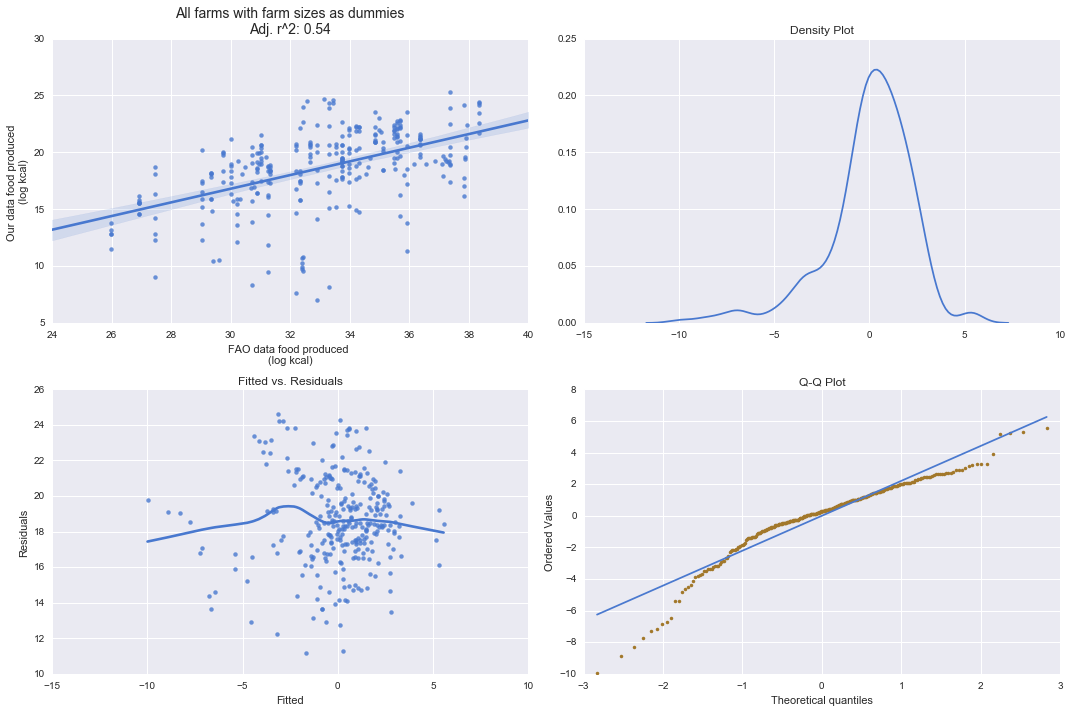

In [820]:
plot_regression(data_endog, data_exog, glsar_results)
# np.shape(data_endog[:, 0])